# C4KC-KiTS: 3D U-Net End-to-End Pipeline (DICOM → NIfTI prep + MONAI training)

This notebook prepares C4KC-KiTS data from DICOM folders to paired NIfTI files, then trains a **3D U-Net** in MONAI.

### What you get
- **Preparation:** DICOM series (arterial / non-contrast / late) → NIfTI images; segmentation conversion (NIfTI or DICOM-SEG if available)
- **Training:** 3D U-Net with 3D augmentations, sliding-window inference, Dice evaluation

### Assumptions
- Raw data lives under a directory like: `Kidney/manifest-.../C4KC-KiTS/KiTS-00000/.../7.000000-arterial-...`
- Labels are 0=background, 1=kidney, 2=tumor

### Steps
1. Install dependencies
2. Configure input/output paths
3. Convert DICOM → NIfTI (imagesTr/labelsTr)
4. Train a MONAI 3D U-Net

**Tip:** Start with small ROI and AMP enabled if GPU memory is tight.

## 1) Install dependencies

In [1]:
# If running locally/Colab, uncomment these:
# !pip install --upgrade pip
# !pip install SimpleITK pydicom highdicom
# !pip install monai[all] torch torchvision torchaudio nibabel

## 2) Configure paths and phase preference

In [12]:
from pathlib import Path

from pathlib import Path

# === base paths ===
RAW_ROOT = Path("/home/philipdt/IKT-project/Kidney/manifest-1592488683281")
OUT_ROOT = Path("/home/philipdt/IKT-project/kits_prepared")

# === output folders ===
IMG_DIR = OUT_ROOT / "imagesTr"
LBL_DIR = OUT_ROOT / "labelsTr"
IMG_DIR.mkdir(parents=True, exist_ok=True)
LBL_DIR.mkdir(parents=True, exist_ok=True)

# Phase preference order for the image series (edit to taste):
PHASE_PREFERENCE = ["arterial", "non-contrast", "late"]

OUT_ROOT.mkdir(parents=True, exist_ok=True)
(OUT_ROOT/"imagesTr").mkdir(parents=True, exist_ok=True)
(OUT_ROOT/"labelsTr").mkdir(parents=True, exist_ok=True)
print("RAW_ROOT:", RAW_ROOT.resolve())
print("OUT_ROOT:", OUT_ROOT.resolve())

RAW_ROOT: /home/philipdt/IKT-project/Kidney/manifest-1592488683281
OUT_ROOT: /home/philipdt/IKT-project/kits_prepared


## 3) DICOM → NIfTI conversion utilities

In [13]:
# === Cell 3: DICOM → NIfTI utilities (images) + label conversion (NIfTI preferred, else DICOM-SEG) ===
import os, re, shutil
from typing import Dict, List, Optional
from pathlib import Path
import numpy as np
import pydicom
import SimpleITK as sitk

def is_phase_dir(p: Path) -> bool:
    return p.is_dir() and any(k in p.name.lower() for k in ["arterial", "non-contrast", "late"])

def is_seg_dir(p: Path) -> bool:
    return p.is_dir() and ("seg" in p.name.lower())

def collect_phase_dirs(study_dir: Path) -> Dict[str, Path]:
    d: Dict[str, Path] = {}
    for sd in study_dir.iterdir():
        nm = sd.name.lower()
        for k in ["arterial", "non-contrast", "late"]:
            if k in nm and sd.is_dir():
                d[k] = sd
    return d

def find_seg_dir(study_dir: Path) -> Optional[Path]:
    for sd in study_dir.iterdir():
        if is_seg_dir(sd):
            return sd
    return None

def select_phase_dir(phase_dirs: Dict[str, Path], preference: List[str]) -> Optional[Path]:
    for pref in preference:
        if pref in phase_dirs:
            print(f"[INFO] Using phase: {pref} -> {phase_dirs[pref]}")
            return phase_dirs[pref]
    return None

def dicom_series_to_nifti(series_dir: Path, out_path: Path):
    reader = sitk.ImageSeriesReader()
    file_names = reader.GetGDCMSeriesFileNames(str(series_dir))
    reader.SetFileNames(file_names)
    img = reader.Execute()
    sitk.WriteImage(img, str(out_path))
    print(f"[OK] Wrote image: {out_path}")

def empty_mask_like(ref_nifti: Path, out_path: Path):
    ref = sitk.ReadImage(str(ref_nifti))
    mask = sitk.Image(ref.GetSize(), sitk.sitkUInt8)
    mask.SetSpacing(ref.GetSpacing())
    mask.SetOrigin(ref.GetOrigin())
    mask.SetDirection(ref.GetDirection())
    sitk.WriteImage(mask, str(out_path))
    print(f"[OK] Wrote empty label: {out_path}")

# --------- DICOM-SEG decoding (lean, no highdicom) ----------
def _map_seg_name_to_label(name: str) -> int:
    n = (name or "").lower()
    if any(k in n for k in ["tumor","tumour","mass","lesion","neoplasm"]): return 2
    if any(k in n for k in ["kidney","renal"]): return 1
    return 0

def _read_ref_axis(ref_path: Path):
    ref = sitk.ReadImage(str(ref_path))
    size = ref.GetSize()
    spacing = ref.GetSpacing()
    origin = np.array(ref.GetOrigin(), float)
    direction = np.array(ref.GetDirection(), float).reshape(3,3)
    k_axis = direction[:, 2]
    slice_z = np.array([(origin + k_axis*spacing[2]*k).dot(k_axis) for k in range(size[2])])
    return ref, size, k_axis, slice_z

def _resample_mask_nn(mask2d_bool: np.ndarray, target_wh: tuple[int,int]) -> np.ndarray:
    img = sitk.GetImageFromArray(mask2d_bool.astype(np.uint8))
    res = sitk.Resample(img, size=(target_wh[0], target_wh[1]), interpolator=sitk.sitkNearestNeighbor)
    return sitk.GetArrayFromImage(res).astype(bool)

def _convert_dicom_seg_to_label(seg_file: Path, ref_image_nii: Path, out_label_nii: Path):
    ref, size, k_axis, slice_z = _read_ref_axis(ref_image_nii)
    ds = pydicom.dcmread(str(seg_file))
    frames = ds.pixel_array.astype(bool)
    pf_seq = ds.PerFrameFunctionalGroupsSequence
    segnum_to_label = {seg.SegmentNumber: _map_seg_name_to_label(seg.SegmentLabel) for seg in ds.SegmentSequence}
    vol = np.zeros((size[2], size[1], size[0]), dtype=np.uint8)
    for i, pf in enumerate(pf_seq):
        seg_num = pf.SegmentIdentificationSequence[0].ReferencedSegmentNumber
        lab = segnum_to_label.get(seg_num, 0)
        if lab == 0:
            continue
        ipp = np.array(pf.PlanePositionSequence[0].ImagePositionPatient, float)
        z_idx = int(np.abs(slice_z - ipp.dot(k_axis)).argmin())
        mask2d = frames[i]
        if mask2d.shape != (size[1], size[0]):
            mask2d = _resample_mask_nn(mask2d, (size[0], size[1]))
        vol[z_idx][mask2d] = np.maximum(vol[z_idx][mask2d], lab)
    out = sitk.GetImageFromArray(vol)
    out.CopyInformation(ref)
    sitk.WriteImage(out, str(out_label_nii))

def convert_seg(seg_dir: Path, ref_image_nifti: Path, out_label_nifti: Path):
    nii_candidates = list(seg_dir.glob("*.nii*"))
    if nii_candidates:
        shutil.copy2(nii_candidates[0], out_label_nifti)
        print(f"[OK] Copied NIfTI label from {nii_candidates[0]} → {out_label_nifti}")
        return
    seg_file = None
    for p in sorted(seg_dir.glob("*.dcm")):
        meta = pydicom.dcmread(str(p), stop_before_pixels=True, force=True)
        if getattr(meta, "Modality", None) == "SEG":
            seg_file = p; break
    if seg_file is not None:
        _convert_dicom_seg_to_label(seg_file, ref_image_nifti, out_label_nifti)
        print(f"[OK] Wrote label from DICOM-SEG: {out_label_nifti}")
        return
    empty_mask_like(ref_image_nifti, out_label_nifti)

from monai.transforms import MapTransform

class ExtractTumorMaskd(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
    def __call__(self, data):
        d = dict(data)
        # assume d["label"] is (1, D, H, W) with 0=bg,1=kidney,2=tumor
        label = d["label"]
        tumor = (label == 2).astype(label.dtype)  # same shape
        d["tumor_mask"] = tumor
        return d



### Run the conversion for all cases

In [14]:
# Convert only if outputs don't already exist (idempotent)
cases = sorted([p for p in (RAW_ROOT / "C4KC-KiTS").glob("KiTS-*") if p.is_dir()])

for case in cases:
    cid = case.name
    img_out = IMG_DIR / f"{cid}.nii.gz"
    lbl_out = LBL_DIR / f"{cid}.nii.gz"

    # Skip whole case if both outputs already exist
    if img_out.exists() and lbl_out.exists():
        print(f"[SKIP] {cid}: image+label already exist")
        continue

    # Find the study folder that contains phases/segmentation
    candidate_dirs = [p for p in case.glob("**/*") if p.is_dir() and re.search(r"threephase|abdomen|phase", p.name, re.I)]
    if not candidate_dirs:
        candidate_dirs = [p for p in case.iterdir() if p.is_dir()]
    study_dir = None
    for p in sorted(candidate_dirs, key=lambda x: len(str(x)), reverse=True):
        subs = [s for s in p.iterdir() if s.is_dir()]
        if any(is_phase_dir(sd) or is_seg_dir(sd) for sd in subs):
            study_dir = p
            break
    if study_dir is None:
        print(f"[WARN] {cid}: no study dir with phases/seg; skipping")
        continue

    phase_dirs = collect_phase_dirs(study_dir)
    seg_dir = find_seg_dir(study_dir)

    # --- Image conversion (only if missing) ---
    if not img_out.exists():
        img_dir = select_phase_dir(phase_dirs, PHASE_PREFERENCE)
        if img_dir is None:
            print(f"[WARN] {cid}: no preferred phase found; skipping image")
        else:
            dicom_series_to_nifti(img_dir, img_out)
    else:
        print(f"[SKIP] {cid}: image exists")

    # --- Label conversion (only if missing) ---
    if not lbl_out.exists():
        # need a reference image path; if we didn't create it now, it should already exist
        if img_out.exists() and seg_dir is not None:
            convert_seg(seg_dir, img_out, lbl_out)
        elif img_out.exists():
            # no segmentation folder → write empty (or remove this line if you don't want empties)
            empty_mask_like(img_out, lbl_out)
        else:
            print(f"[WARN] {cid}: no image to align label; skipping label")
    else:
        print(f"[SKIP] {cid}: label exists")


[SKIP] KiTS-00000: image+label already exist
[SKIP] KiTS-00001: image+label already exist
[SKIP] KiTS-00002: image+label already exist
[SKIP] KiTS-00003: image+label already exist
[SKIP] KiTS-00004: image+label already exist
[SKIP] KiTS-00005: image+label already exist
[SKIP] KiTS-00006: image+label already exist
[SKIP] KiTS-00007: image+label already exist
[SKIP] KiTS-00008: image+label already exist
[SKIP] KiTS-00009: image+label already exist
[SKIP] KiTS-00010: image+label already exist
[SKIP] KiTS-00011: image+label already exist
[SKIP] KiTS-00012: image+label already exist
[SKIP] KiTS-00013: image+label already exist
[SKIP] KiTS-00014: image+label already exist
[SKIP] KiTS-00015: image+label already exist
[SKIP] KiTS-00016: image+label already exist
[SKIP] KiTS-00017: image+label already exist
[SKIP] KiTS-00018: image+label already exist
[SKIP] KiTS-00019: image+label already exist
[SKIP] KiTS-00020: image+label already exist
[SKIP] KiTS-00021: image+label already exist
[SKIP] KiT

In [15]:
# === Build train/val file lists + MONAI transforms (no cfg) ===
from pathlib import Path
from typing import Tuple
import re

from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd, ScaleIntensityRanged,
    CropForegroundd, SpatialPadd, RandCropByPosNegLabeld, RandAffined, EnsureTyped, DivisiblePadd
)

# ---------- paths ----------
OUT_ROOT = Path("./kits_prepared")   # change if your prepared data lives elsewhere
IMG_DIR  = OUT_ROOT / "imagesTr"
LBL_DIR  = OUT_ROOT / "labelsTr"

def _case_id(p: Path):
    s = p.name
    if s.endswith(".nii.gz"): return s[:-7]
    if s.endswith(".nii"):    return s[:-4]
    return s

# collect overlapping pairs only
ims = sorted(IMG_DIR.glob("*.nii*"))
lbs = sorted(LBL_DIR.glob("*.nii*"))
img_ids = {_case_id(p) for p in ims}
lbl_ids = {_case_id(p) for p in lbs}
ids = sorted(img_ids & lbl_ids)
assert ids, "No overlapping image/label pairs found."

pairs = []
for cid in ids:
    img = next(p for p in ims if _case_id(p)==cid)
    lbl = next(p for p in lbs if _case_id(p)==cid)
    pairs.append({"image": str(img), "label": str(lbl)})

# 70/15/15 split (shuffled, reproducible)
import random
random.seed(42)
random.shuffle(pairs)

n_total = len(pairs)
n_train = int(0.70 * n_total)
n_val   = int(0.15 * n_total)
# remaining goes to test to ensure full coverage
train_files = pairs[:n_train]
val_files   = pairs[n_train:n_train + n_val]
test_files  = pairs[n_train + n_val:]

print(f"Using {len(train_files)} train / {len(val_files)} val / {len(test_files)} test pairs.")

# ---------- transform hyperparams (match your training cell) ----------
pixdim: Tuple[float,float,float] = (2.0, 2.0, 2.0)
roi_size: Tuple[int,int,int]     = (96, 96, 96)

# ---------- transforms ----------
train_transforms = Compose([
    LoadImaged(keys=["image","label"]),
    EnsureChannelFirstd(keys=["image","label"]),
    Orientationd(keys=["image","label"], axcodes="RAS"),
    Spacingd(keys=["image","label"], pixdim=pixdim, mode=("bilinear","nearest")),
    ScaleIntensityRanged(keys=["image"], a_min=-200, a_max=300, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image","label"], source_key="image"),
    SpatialPadd(keys=["image","label"], spatial_size=roi_size),
    ExtractTumorMaskd(keys=["label"]),
    RandCropByPosNegLabeld(
        keys=["image","label"], label_key="tumor_mask", spatial_size=roi_size,
        pos=3, neg=1, num_samples=4, image_key="image", image_threshold=0, allow_smaller=True
    ),

    RandAffined(
        keys=["image","label"], prob=0.3,
        rotate_range=(0.1,0.1,0.1), scale_range=(0.1,0.1,0.1),
        mode=("bilinear","nearest"), padding_mode="border"
    ),
    EnsureTyped(keys=["image","label"]),
    DivisiblePadd(keys=["image","label"], k=8),  # keep dims multiple of 8 for UNet
])

val_transforms = Compose([
    LoadImaged(keys=["image","label"]),
    EnsureChannelFirstd(keys=["image","label"]),
    Orientationd(keys=["image","label"], axcodes="RAS"),
    Spacingd(keys=["image","label"], pixdim=pixdim, mode=("bilinear","nearest")),
    ScaleIntensityRanged(keys=["image"], a_min=-200, a_max=300, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image","label"], source_key="image"),
    SpatialPadd(keys=["image","label"], spatial_size=roi_size),
    EnsureTyped(keys=["image","label"]),
    DivisiblePadd(keys=["image","label"], k=8),
])


Using 147 train / 31 val / 32 test pairs.


/home/philipdt/.local/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


## 4) Train a MONAI 3D U-Net

In [16]:
# === Cell 1: datasets & dataloaders ===
import os, gc, csv, torch, numpy as np
from pathlib import Path
from tqdm import tqdm

from monai.data import CacheDataset, pad_list_data_collate
from torch.utils.data import DataLoader

# ----------------------------
# CONFIG
# ----------------------------
max_epochs   = 100       # or fewer while debugging
batch_size   = 1         # 3D KiTS → usually 1
lr           = 2e-4
roi_size     = (96, 96, 96)   # keep as you had it
num_classes  = 3         # 0=background, 1=kidney, 2=tumor
amp_enabled  = True

# Root folder for all runs
root_dir = Path("./outputs_3d_unet")
root_dir.mkdir(parents=True, exist_ok=True)

# -------------------------------------------------
# Create a new subfolder for this run: run1, run2…
# -------------------------------------------------
existing_runs = [
    d for d in root_dir.iterdir()
    if d.is_dir() and d.name.startswith("run")
]

if existing_runs:
    def _run_num(d):
        s = d.name[3:]  # after "run"
        return int(s) if s.isdigit() else 0

    next_idx = max(_run_num(d) for d in existing_runs) + 1
else:
    next_idx = 1

run_dir = root_dir / f"run{next_idx}"
run_dir.mkdir(parents=True, exist_ok=True)

print(f"🔹 Saving models and history to: {run_dir}")

# Use run_dir everywhere else
ckpt_path = run_dir / "model_best.pth"
out_dir   = run_dir

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ.setdefault(
    "PYTORCH_CUDA_ALLOC_CONF",
    "expandable_segments:True,max_split_size_mb:64"
)

# ----------------------------
# CacheDataset creation
# (assumes train_files, val_files, train_transforms, val_transforms already defined)
# ----------------------------
train_ds = CacheDataset(
    data=train_files,
    transform=train_transforms,
    cache_rate=1.0,      # lower if RAM is tight (e.g. 0.5)
    num_workers=4,
)

val_ds = CacheDataset(
    data=val_files,
    transform=val_transforms,
    cache_rate=1.0,
    num_workers=4,
)

# ----------------------------
# DataLoaders
# ----------------------------
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    collate_fn=pad_list_data_collate,   
)

val_loader = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)

test_ds = CacheDataset(
    data=test_files,
    transform=val_transforms,   # deterministic transforms for evaluation
    cache_rate=1.0,
    num_workers=4,
)

test_loader = DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)

print("Datasets and DataLoaders ready (train/val/test).")


🔹 Saving models and history to: outputs_3d_unet/run15


Loading dataset: 100%|██████████| 32/32 [00:44<00:00,  1.39s/it]

Datasets and DataLoaders ready (train/val/test).


In [10]:
# === Cell 2: model, optimizer, loss, metric, logging ===
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete

# ----------------------------
# Model + optimizer + loss
# ----------------------------
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=num_classes,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2,2),
    num_res_units=2,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)

from monai.losses import DiceLoss
import torch.nn.functional as F

# 2 foreground classes for multi-class dice: [kidney, tumor]
dice_weight = torch.tensor([1.0, 1.0], device=device)  # start unweighted here again

dice_loss_mc = DiceLoss(
    to_onehot_y=True,
    softmax=True,
    include_background=False,
    weight=dice_weight,
)

# 3 classes for CE: [background, kidney, tumor]
ce_weight = torch.tensor([0.5, 1.0, 3.0], device=device)  # still bias CE a bit towards tumor

# binary Dice for tumor-only aux loss
dice_loss_tumor = DiceLoss(
    to_onehot_y=False,
    sigmoid=False,
    include_background=True,
)

lambda_tumor = 2.0  # you can try 1.0, 2.0, 3.0

def loss_fn(logits, labels):
    # logits: (B, 3, D, H, W)
    # labels: (B, 1, D, H, W)

    # --- multi-class losses ---
    ce = F.cross_entropy(
        logits,
        labels.squeeze(1).long(),
        weight=ce_weight,
    )
    dice_mc = dice_loss_mc(logits, labels)

    # --- tumor-only aux loss ---
    prob = torch.softmax(logits, dim=1)       # (B,3,D,H,W)
    tumor_prob = prob[:, 2:3]                 # (B,1,D,H,W)
    tumor_gt   = (labels == 2).float()        # (B,1,D,H,W)

    loss_tumor = dice_loss_tumor(tumor_prob, tumor_gt)

    return dice_mc + ce + lambda_tumor * loss_tumor


# Mixed precision
scaler = torch.amp.GradScaler("cuda", enabled=amp_enabled)

# Post transforms
post_pred  = AsDiscrete(argmax=True, to_onehot=3)
post_label = AsDiscrete(to_onehot=3)

# Dice metric: per-class (foreground only), averaged over batch
dice_metric = DiceMetric(
    include_background=False,   # ignore background channel
    reduction="mean_batch",     # returns shape (C,) where C = #foreground classes
    get_not_nans=False,
)

# ----------------------------
# CSV logging setup
# ----------------------------
hist_csv = out_dir / "history.csv"
if not hist_csv.exists():
    with open(hist_csv, "w", newline="") as f:
        csv.writer(f).writerow(["epoch", "train_loss", "val_loss", "val_dice"])


best_val_loss = float("inf")

print("Model, optimizer, loss, metric, and logging initialized.")


Model, optimizer, loss, metric, and logging initialized.


In [ ]:
from monai.inferers import sliding_window_inference

for epoch in tqdm(range(1, max_epochs + 1), desc="Epochs", leave=True, dynamic_ncols=True):
    model.train()
    epoch_loss = 0.0

    # ----------------------------
    # TRAIN
    # ----------------------------
    for batch in train_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)   # (B,1,D,H,W) with {0,1,2}

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast("cuda", enabled=amp_enabled):
            logits = model(images)
            loss = loss_fn(logits, labels)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / max(1, len(train_loader))

    # ----------------------------
    # VALIDATION — loss + manual Dice
    # ----------------------------
    model.eval()

    num   = torch.zeros(2, device=device)   # [kidney, tumor] numerator
    denom = torch.zeros(2, device=device)   # [kidney, tumor] denominator
    val_epoch_loss = 0.0                    # <--- NEW: accumulate val loss

    with torch.no_grad():
        for val_data in val_loader:
            images = val_data["image"].to(device)
            labels = val_data["label"].to(device)

            with torch.amp.autocast("cuda", enabled=amp_enabled):
                logits = sliding_window_inference(
                    images,
                    roi_size=roi_size,
                    sw_batch_size=1,
                    predictor=model,
                    overlap=0.5,
                )
                # <--- NEW: validation loss on full-volume logits
                val_loss_batch = loss_fn(logits, labels)
            val_epoch_loss += val_loss_batch.item()

            preds = torch.argmax(logits, dim=1)   # (B,D,H,W)

            if labels.dim() == 5:
                gts = labels.squeeze(1)
            else:
                gts = labels

            for ci, cls in enumerate([1, 2]):   # 1=kidney, 2=tumor
                p = (preds == cls)
                g = (gts   == cls)

                inter = (p & g).sum()
                d = p.sum() + g.sum()

                num[ci]   += 2.0 * inter
                denom[ci] += d

    # average validation loss over batches
    val_loss = val_epoch_loss / max(1, len(val_loader))

    per_class_torch = torch.where(
        denom > 0,
        num / denom,
        torch.full_like(denom, float("nan"))
    )

    per_class = per_class_torch.detach().cpu().numpy().astype(float)
    kidney_dice = float(per_class[0])
    tumor_dice  = float(per_class[1])

    finite_mask = np.isfinite(per_class)
    mean_dice = float(per_class[finite_mask].mean()) if finite_mask.any() else float("nan")
    val_dice = mean_dice

    # ----------------------------
    # LOGGING & CHECKPOINTS
    # ----------------------------
    # NOTE: if you want val_loss in CSV too, also log it here
    with open(hist_csv, "a", newline="") as f:
        csv.writer(f).writerow([epoch, f"{avg_loss:.6f}", f"{val_loss:.6f}", f"{val_dice:.6f}"])

    # best model based on *validation loss*
    if np.isfinite(val_loss) and val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(
            {"model": model.state_dict(), "epoch": epoch, "val_loss": val_loss},
            ckpt_path,
        )

    # always save last model
    torch.save(
        {"model": model.state_dict(), "epoch": epoch, "dice": val_dice},
        out_dir / "last.pth",
    )

    print(
        f"Epoch {epoch:03d} | "
        f"train_loss {avg_loss:.4f} | val_loss {val_loss:.4f} | "
        f"kidney {kidney_dice:.4f} | tumor {tumor_dice:.4f} | "
        f"mean_dice {mean_dice:.4f} | best_val_loss {best_val_loss:.4f}"
    )

    torch.cuda.empty_cache()
    gc.collect()


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]/home/philipdt/.local/lib/python3.10/site-packages/monai/inferers/utils.py:231: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = inputs[unravel_slice[0]].to(sw_device)
/home/philipdt/.local/lib/python3.10/site-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_v

Epoch 001 | train_loss 3.6063 | val_loss 3.3048 | kidney 0.2681 | tumor 0.0755 | mean_dice 0.1718 | best_val_loss 3.3048


Epochs:   1%|          | 1/100 [00:37<1:01:45, 37.43s/it]

Epoch 002 | train_loss 3.1377 | val_loss 3.0648 | kidney 0.3988 | tumor 0.1217 | mean_dice 0.2602 | best_val_loss 3.0648


Epochs:   2%|▏         | 2/100 [01:05<51:55, 31.79s/it]  

Epoch 003 | train_loss 2.8920 | val_loss 2.9639 | kidney 0.5189 | tumor 0.0898 | mean_dice 0.3044 | best_val_loss 2.9639


Epochs:   3%|▎         | 3/100 [01:33<48:59, 30.30s/it]

Epoch 004 | train_loss 2.7137 | val_loss 2.8883 | kidney 0.4718 | tumor 0.1062 | mean_dice 0.2890 | best_val_loss 2.8883


Epochs:   4%|▍         | 4/100 [02:01<47:02, 29.40s/it]

Epoch 005 | train_loss 2.5389 | val_loss 2.7968 | kidney 0.5550 | tumor 0.1383 | mean_dice 0.3466 | best_val_loss 2.7968


Epochs:   5%|▌         | 5/100 [02:29<45:49, 28.95s/it]

Epoch 006 | train_loss 2.3435 | val_loss 2.7711 | kidney 0.5075 | tumor 0.1173 | mean_dice 0.3124 | best_val_loss 2.7711


Epochs:   6%|▌         | 6/100 [02:58<44:56, 28.69s/it]

Epoch 007 | train_loss 2.2143 | val_loss 2.6804 | kidney 0.6026 | tumor 0.1416 | mean_dice 0.3721 | best_val_loss 2.6804


Epochs:   7%|▋         | 7/100 [03:25<43:46, 28.25s/it]

Epoch 008 | train_loss 2.1173 | val_loss 2.6853 | kidney 0.6012 | tumor 0.1523 | mean_dice 0.3768 | best_val_loss 2.6804


Epochs:   8%|▊         | 8/100 [03:52<42:40, 27.83s/it]

Epoch 009 | train_loss 2.0200 | val_loss 2.5902 | kidney 0.6432 | tumor 0.1973 | mean_dice 0.4203 | best_val_loss 2.5902


Epochs:   9%|▉         | 9/100 [04:20<42:10, 27.80s/it]

Epoch 010 | train_loss 1.8579 | val_loss 2.6182 | kidney 0.7017 | tumor 0.0743 | mean_dice 0.3880 | best_val_loss 2.5902


Epochs:  10%|█         | 10/100 [04:47<41:25, 27.62s/it]

Epoch 011 | train_loss 1.9028 | val_loss 2.5542 | kidney 0.5759 | tumor 0.2835 | mean_dice 0.4297 | best_val_loss 2.5542


Epochs:  11%|█         | 11/100 [05:14<40:56, 27.60s/it]

Epoch 012 | train_loss 1.7538 | val_loss 2.5462 | kidney 0.6555 | tumor 0.2369 | mean_dice 0.4462 | best_val_loss 2.5462


Epochs:  12%|█▏        | 12/100 [05:42<40:28, 27.59s/it]

Epoch 013 | train_loss 1.6929 | val_loss 2.4885 | kidney 0.7014 | tumor 0.2811 | mean_dice 0.4913 | best_val_loss 2.4885


Epochs:  13%|█▎        | 13/100 [06:09<39:39, 27.36s/it]

Epoch 014 | train_loss 1.6376 | val_loss 2.4954 | kidney 0.6976 | tumor 0.2630 | mean_dice 0.4803 | best_val_loss 2.4885


Epochs:  14%|█▍        | 14/100 [06:36<39:09, 27.32s/it]

Epoch 015 | train_loss 1.6375 | val_loss 2.3745 | kidney 0.7654 | tumor 0.3348 | mean_dice 0.5501 | best_val_loss 2.3745


Epochs:  15%|█▌        | 15/100 [07:03<38:32, 27.21s/it]

Epoch 016 | train_loss 1.4560 | val_loss 2.3970 | kidney 0.7224 | tumor 0.3140 | mean_dice 0.5182 | best_val_loss 2.3745


Epochs:  16%|█▌        | 16/100 [07:29<37:42, 26.94s/it]

Epoch 017 | train_loss 1.4935 | val_loss 2.4495 | kidney 0.7434 | tumor 0.2483 | mean_dice 0.4958 | best_val_loss 2.3745


Epochs:  17%|█▋        | 17/100 [07:58<37:54, 27.41s/it]

Epoch 018 | train_loss 1.5145 | val_loss 2.3169 | kidney 0.6790 | tumor 0.4273 | mean_dice 0.5532 | best_val_loss 2.3169


Epochs:  18%|█▊        | 18/100 [08:25<37:25, 27.39s/it]

Epoch 019 | train_loss 1.3918 | val_loss 2.2937 | kidney 0.7772 | tumor 0.4182 | mean_dice 0.5977 | best_val_loss 2.2937


Epochs:  19%|█▉        | 19/100 [08:53<37:06, 27.48s/it]

Epoch 020 | train_loss 1.3435 | val_loss 2.2160 | kidney 0.7938 | tumor 0.4390 | mean_dice 0.6164 | best_val_loss 2.2160


Epochs:  20%|██        | 20/100 [09:20<36:29, 27.37s/it]

Epoch 021 | train_loss 1.3889 | val_loss 2.2229 | kidney 0.7919 | tumor 0.5379 | mean_dice 0.6649 | best_val_loss 2.2160


Epochs:  21%|██        | 21/100 [09:47<35:54, 27.28s/it]

Epoch 022 | train_loss 1.3555 | val_loss 2.2028 | kidney 0.8272 | tumor 0.5271 | mean_dice 0.6771 | best_val_loss 2.2028


Epochs:  22%|██▏       | 22/100 [10:15<35:44, 27.50s/it]

Epoch 023 | train_loss 1.2356 | val_loss 2.0818 | kidney 0.8225 | tumor 0.5039 | mean_dice 0.6632 | best_val_loss 2.0818


Epochs:  23%|██▎       | 23/100 [10:44<35:41, 27.81s/it]

Epoch 024 | train_loss 1.2075 | val_loss 2.1222 | kidney 0.7843 | tumor 0.5640 | mean_dice 0.6742 | best_val_loss 2.0818


Epochs:  24%|██▍       | 24/100 [11:11<35:08, 27.75s/it]

Epoch 025 | train_loss 1.2364 | val_loss 2.1346 | kidney 0.7543 | tumor 0.5648 | mean_dice 0.6595 | best_val_loss 2.0818


Epochs:  25%|██▌       | 25/100 [11:38<34:25, 27.54s/it]

Epoch 026 | train_loss 1.2241 | val_loss 2.0947 | kidney 0.8142 | tumor 0.5501 | mean_dice 0.6822 | best_val_loss 2.0818


Epochs:  26%|██▌       | 26/100 [12:05<33:49, 27.43s/it]

Epoch 027 | train_loss 1.1353 | val_loss 2.0425 | kidney 0.8404 | tumor 0.6151 | mean_dice 0.7277 | best_val_loss 2.0425


Epochs:  27%|██▋       | 27/100 [12:33<33:23, 27.45s/it]

Epoch 028 | train_loss 1.2609 | val_loss 2.0570 | kidney 0.8367 | tumor 0.6035 | mean_dice 0.7201 | best_val_loss 2.0425


Epochs:  28%|██▊       | 28/100 [13:02<33:34, 27.98s/it]

Epoch 029 | train_loss 1.1881 | val_loss 1.9882 | kidney 0.8565 | tumor 0.6891 | mean_dice 0.7728 | best_val_loss 1.9882


Epochs:  29%|██▉       | 29/100 [13:30<32:55, 27.83s/it]

Epoch 030 | train_loss 1.1303 | val_loss 1.9928 | kidney 0.8229 | tumor 0.6464 | mean_dice 0.7347 | best_val_loss 1.9882


Epochs:  30%|███       | 30/100 [13:58<32:34, 27.92s/it]

Epoch 031 | train_loss 1.0277 | val_loss 1.9108 | kidney 0.8545 | tumor 0.7082 | mean_dice 0.7814 | best_val_loss 1.9108


Epochs:  31%|███       | 31/100 [14:26<32:09, 27.97s/it]

Epoch 032 | train_loss 1.0925 | val_loss 1.9664 | kidney 0.8148 | tumor 0.6174 | mean_dice 0.7161 | best_val_loss 1.9108


Epochs:  32%|███▏      | 32/100 [14:53<31:33, 27.84s/it]

Epoch 033 | train_loss 1.1387 | val_loss 1.9898 | kidney 0.8399 | tumor 0.6105 | mean_dice 0.7252 | best_val_loss 1.9108


Epochs:  33%|███▎      | 33/100 [15:22<31:27, 28.17s/it]

Epoch 034 | train_loss 1.0642 | val_loss 1.8688 | kidney 0.8528 | tumor 0.7253 | mean_dice 0.7891 | best_val_loss 1.8688


Epochs:  34%|███▍      | 34/100 [15:50<30:40, 27.89s/it]

Epoch 035 | train_loss 1.0876 | val_loss 1.9063 | kidney 0.8611 | tumor 0.7178 | mean_dice 0.7894 | best_val_loss 1.8688


Epochs:  35%|███▌      | 35/100 [16:17<30:13, 27.90s/it]

Epoch 036 | train_loss 0.9902 | val_loss 1.9782 | kidney 0.8319 | tumor 0.6406 | mean_dice 0.7363 | best_val_loss 1.8688


Epochs:  36%|███▌      | 36/100 [16:45<29:32, 27.70s/it]

Epoch 037 | train_loss 1.0894 | val_loss 2.1668 | kidney 0.7917 | tumor 0.4110 | mean_dice 0.6013 | best_val_loss 1.8688


Epochs:  37%|███▋      | 37/100 [17:12<28:54, 27.52s/it]

Epoch 038 | train_loss 1.1096 | val_loss 2.0223 | kidney 0.8372 | tumor 0.6110 | mean_dice 0.7241 | best_val_loss 1.8688


Epochs:  38%|███▊      | 38/100 [17:39<28:15, 27.35s/it]

Epoch 039 | train_loss 0.9991 | val_loss 1.8940 | kidney 0.8809 | tumor 0.6448 | mean_dice 0.7629 | best_val_loss 1.8688


Epochs:  39%|███▉      | 39/100 [18:06<27:38, 27.19s/it]

Epoch 040 | train_loss 1.0654 | val_loss 1.8943 | kidney 0.8369 | tumor 0.6364 | mean_dice 0.7367 | best_val_loss 1.8688


Epochs:  40%|████      | 40/100 [18:34<27:27, 27.45s/it]

Epoch 041 | train_loss 1.1257 | val_loss 1.8560 | kidney 0.8895 | tumor 0.6586 | mean_dice 0.7740 | best_val_loss 1.8560


Epochs:  41%|████      | 41/100 [19:00<26:46, 27.23s/it]

Epoch 042 | train_loss 1.0199 | val_loss 1.9594 | kidney 0.8659 | tumor 0.6719 | mean_dice 0.7689 | best_val_loss 1.8560


Epochs:  42%|████▏     | 42/100 [19:27<26:16, 27.18s/it]

Epoch 043 | train_loss 1.0127 | val_loss 1.8225 | kidney 0.8763 | tumor 0.5444 | mean_dice 0.7104 | best_val_loss 1.8225


Epochs:  43%|████▎     | 43/100 [19:54<25:43, 27.08s/it]

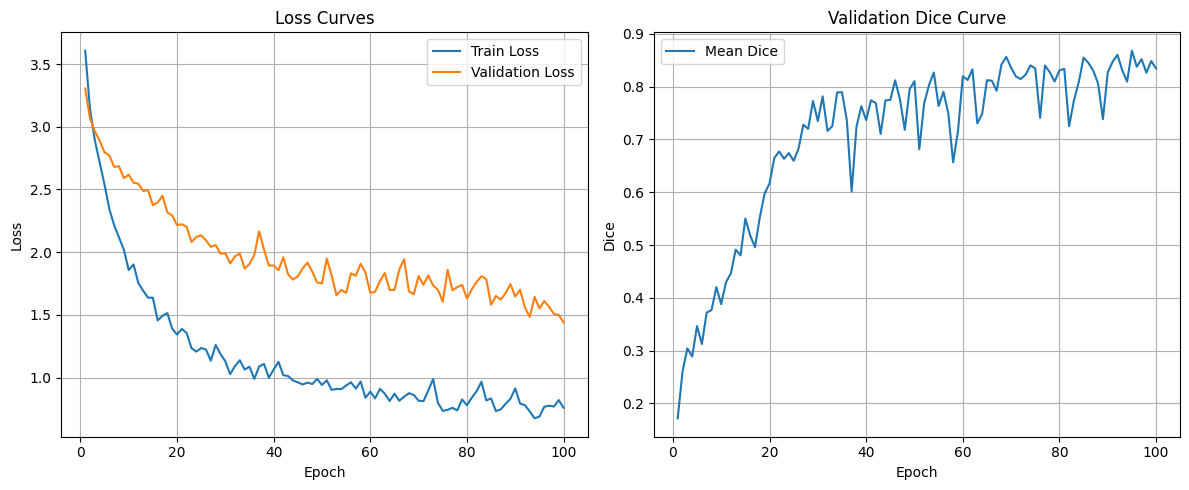

✔ Plots generated and saved.

Loading best model from: outputs_3d_unet/run13/model_best.pth


/home/philipdt/.local/lib/python3.10/site-packages/monai/inferers/utils.py:231: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = inputs[unravel_slice[0]].to(sw_device)
/home/philipdt/.local/lib/python3.10/site-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  out[idx_zm] += p



 BEST MODEL – PER-CLASS DICE 
Kidney Dice: 0.9207
Tumor  Dice: 0.7482
Mean   Dice: 0.8344


In [24]:
# ============================================
# PLOT TRAINING CURVES + EVALUATE BEST MODEL
# ============================================
import csv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from monai.inferers import sliding_window_inference

hist_csv = Path("./outputs_3d_unet/run13/history.csv")

# --------------------------
# Load training history
# --------------------------
# Load only the LAST run from history.csv
epochs = []
train_loss = []
mean_dice = []

temp_epochs = []
temp_loss = []
temp_dice = []
temp_val_dice = []

with open(hist_csv, "r") as f:
    reader = csv.DictReader(f)

    for row in reader:
        ep = int(row["epoch"])

        # Epoch reset → this marks a new run starting
        if ep == 1 and len(temp_epochs) > 0:
            # Commit previous run
            epochs = temp_epochs
            train_loss = temp_loss
            mean_dice = temp_dice
            # reset temp
            temp_epochs = []
            temp_loss = []
            temp_dice = []
            temp_val_dice = []

        temp_epochs.append(ep)
        temp_loss.append(float(row["train_loss"]))
        temp_dice.append(float(row["val_dice"]))
        temp_val_dice.append(float(row["val_loss"]))

# Take the last run
if len(temp_epochs) > 0:
    epochs = temp_epochs
    train_loss = temp_loss
    mean_dice = temp_dice
    val_loss = temp_val_dice

epochs = np.array(epochs)
train_loss = np.array(train_loss)
mean_dice = np.array(mean_dice)
val_loss = np.array(val_loss)


# --------------------------
# Plot curves
# --------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, mean_dice, label="Mean Dice")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.title("Validation Dice Curve")
plt.grid()
plt.legend()

# Save BEFORE show
plt.tight_layout()
plt.savefig("training_curves.png", dpi=300, bbox_inches="tight")

plt.show()

print("✔ Plots generated and saved.")


# ================================
# Evaluate best model checkpoint
# ================================
#best_ckpt = out_dir / "model_best.pth"

best_ckpt = Path("./outputs_3d_unet/run13/model_best.pth")
assert best_ckpt.exists(), "No best checkpoint found!"

print(f"\nLoading best model from: {best_ckpt}")

state = torch.load(best_ckpt, map_location=device)
model.load_state_dict(state["model"])
model.eval()

# ------------------------------------
# Manual Dice for kidney & tumor
# ------------------------------------
num   = torch.zeros(2, device=device)   # numerators for [kidney, tumor]
denom = torch.zeros(2, device=device)   # denominators for [kidney, tumor]

with torch.no_grad():
    for val_data in val_loader:
        images = val_data["image"].to(device)
        labels = val_data["label"].to(device)

        logits = sliding_window_inference(
            images,
            roi_size=roi_size,
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

        preds = torch.argmax(logits, dim=1)

        if labels.dim() == 5:
            gts = labels.squeeze(1)
        else:
            gts = labels

        # class indices: kidney=1, tumor=2
        for ci, cls in enumerate([1, 2]):
            p = preds == cls
            g = gts == cls

            inter = (p & g).sum()
            d = p.sum() + g.sum()

            num[ci]   += 2.0 * inter
            denom[ci] += d

per_class_t = torch.where(
    denom > 0,
    num / denom,
    torch.full_like(denom, float("nan"))
)
per_class = per_class_t.detach().cpu().numpy().astype(float)

kidney_dice = float(per_class[0])
tumor_dice  = float(per_class[1])
finite_mask = np.isfinite(per_class)
mean_dice   = float(per_class[finite_mask].mean()) if finite_mask.any() else float("nan")

print("\n==============================")
print(" BEST MODEL – PER-CLASS DICE ")
print("==============================")
print(f"Kidney Dice: {kidney_dice:.4f}")
print(f"Tumor  Dice: {tumor_dice:.4f}")
print(f"Mean   Dice: {mean_dice:.4f}")
print("==============================")


In [26]:
# ============================================
# FINAL TEST SET EVALUATION (INFERENCE ONLY)
# ============================================

import torch
import numpy as np
from monai.inferers import sliding_window_inference

# Load best model checkpoint
#best_ckpt = out_dir / "model_best.pth"
assert best_ckpt.exists(), "No best checkpoint found!"

print(f"Loading best model from: {best_ckpt}")

state = torch.load(best_ckpt, map_location=device)
model.load_state_dict(state["model"])
model.eval()

# Dice accumulators: [kidney, tumor]
num   = torch.zeros(2, device=device)
denom = torch.zeros(2, device=device)

with torch.no_grad():
    for test_data in test_loader:
        images = test_data["image"].to(device)
        labels = test_data["label"].to(device)

        # Sliding window inference
        logits = sliding_window_inference(
            images,
            roi_size=roi_size,
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

        preds = torch.argmax(logits, dim=1)

        # Handle possible channel dim
        if labels.dim() == 5:
            gts = labels.squeeze(1)
        else:
            gts = labels

        # class indices: kidney=1, tumor=2
        for ci, cls in enumerate([1, 2]):
            p = preds == cls
            g = gts == cls

            inter = (p & g).sum()
            d = p.sum() + g.sum()

            num[ci]   += 2.0 * inter
            denom[ci] += d

# Compute per-class Dice
per_class_t = torch.where(
    denom > 0,
    num / denom,
    torch.full_like(denom, float("nan"))
)

per_class = per_class_t.detach().cpu().numpy().astype(float)

kidney_dice = float(per_class[0])
tumor_dice  = float(per_class[1])
finite_mask = np.isfinite(per_class)
mean_dice   = float(per_class[finite_mask].mean()) if finite_mask.any() else float("nan")

print("\n===================================")
print(" FINAL TEST SET – PER-CLASS DICE ")
print("===================================")
print(f"Kidney Dice: {kidney_dice:.4f}")
print(f"Tumor  Dice: {tumor_dice:.4f}")
print(f"Mean   Dice: {mean_dice:.4f}")
print("===================================")


Loading best model from: outputs_3d_unet/run13/model_best.pth


/home/philipdt/.local/lib/python3.10/site-packages/monai/inferers/utils.py:231: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = inputs[unravel_slice[0]].to(sw_device)
/home/philipdt/.local/lib/python3.10/site-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  out[idx_zm] += p



 FINAL TEST SET – PER-CLASS DICE 
Kidney Dice: 0.9090
Tumor  Dice: 0.8047
Mean   Dice: 0.8568


[sagittal slice 158] Dice scores:
  Kidney Dice   = 0.9740
  Tumor Dice    = 1.0000
  Foreground    = 0.9740



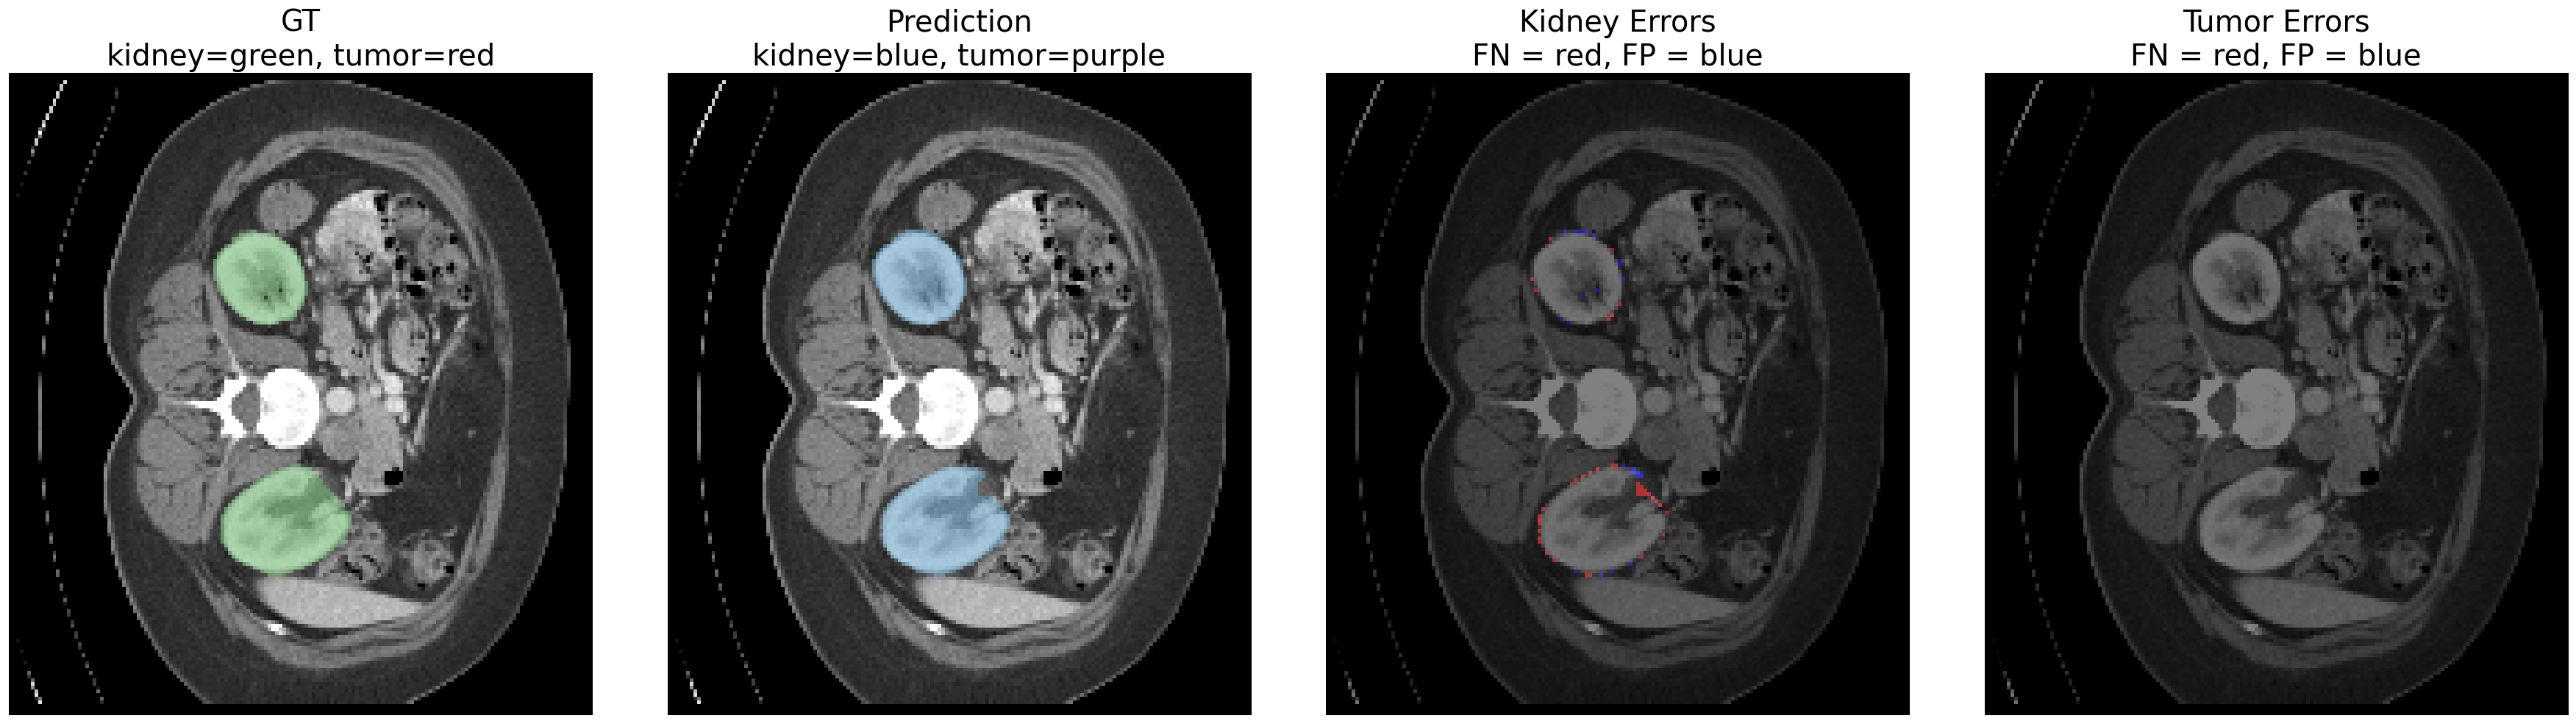

/home/philipdt/.local/lib/python3.10/site-packages/monai/inferers/utils.py:231: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = inputs[unravel_slice[0]].to(sw_device)
/home/philipdt/.local/lib/python3.10/site-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  out[idx_zm] += p


[sagittal slice 82] Dice scores:
  Kidney Dice   = 0.9403
  Tumor Dice    = 0.0000
  Foreground    = 0.9551



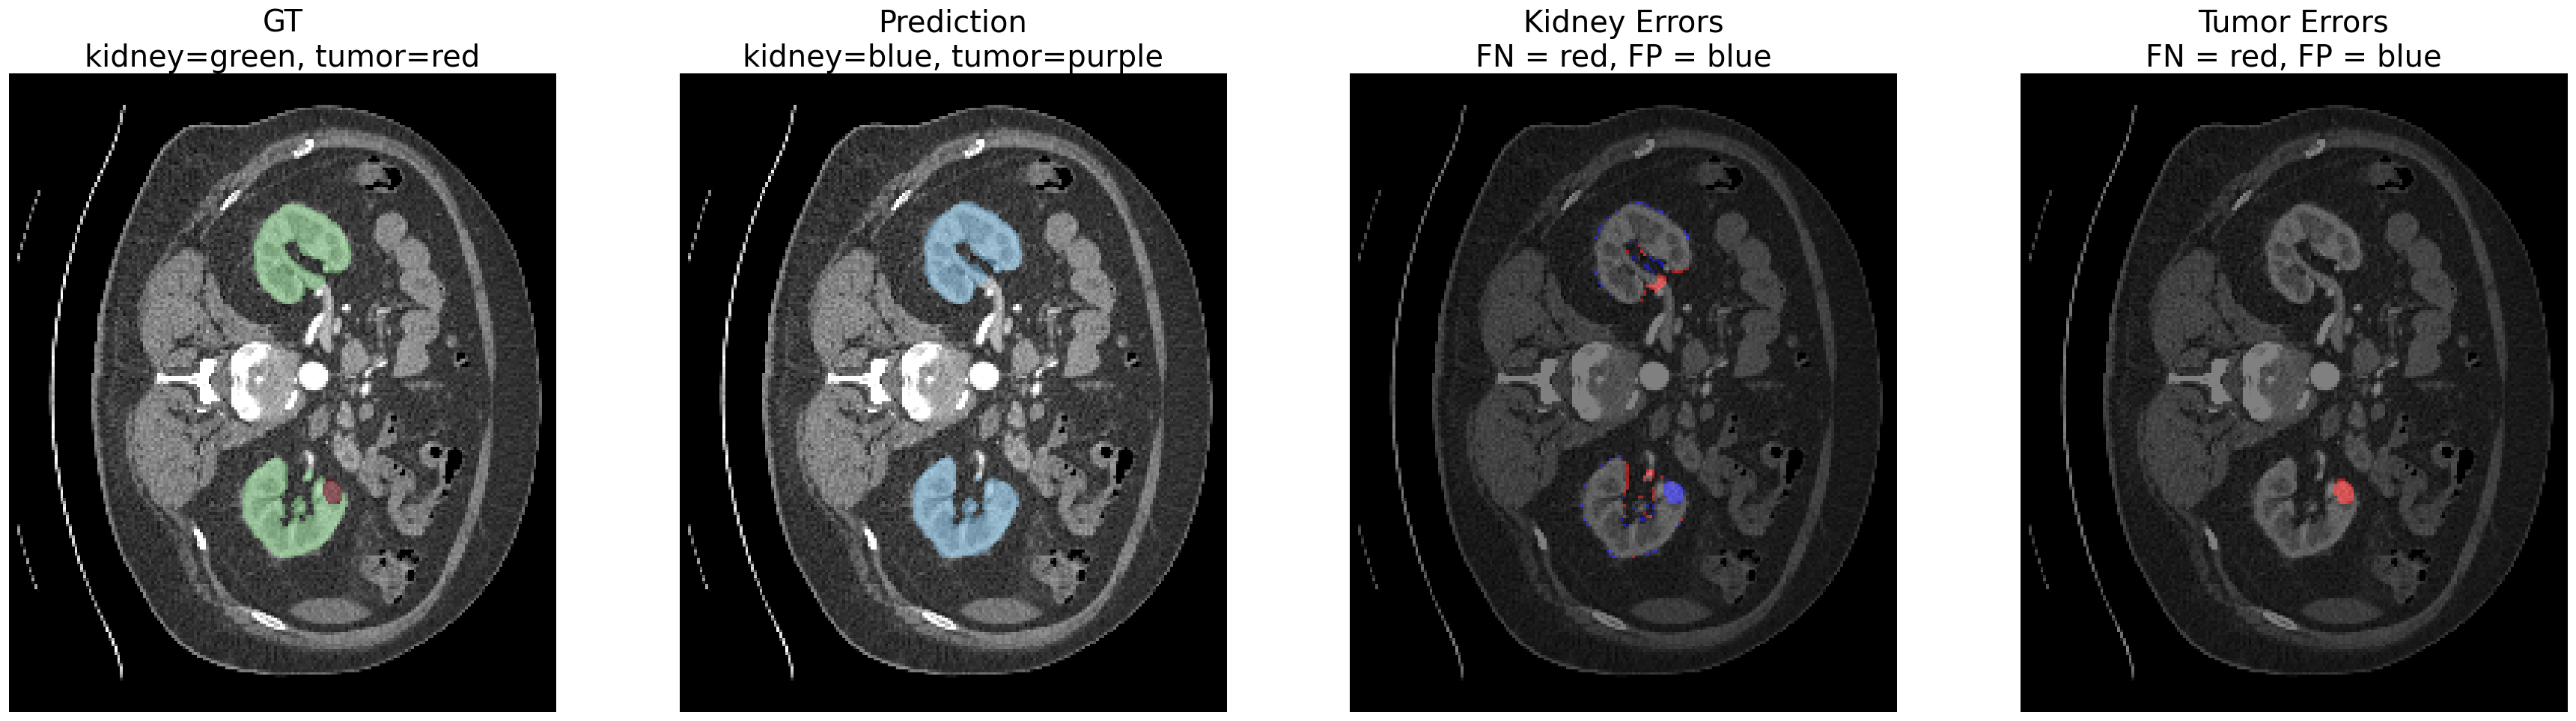

/home/philipdt/.local/lib/python3.10/site-packages/monai/inferers/utils.py:231: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = inputs[unravel_slice[0]].to(sw_device)
/home/philipdt/.local/lib/python3.10/site-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  out[idx_zm] += p


[sagittal slice 89] Dice scores:
  Kidney Dice   = 0.9386
  Tumor Dice    = 1.0000
  Foreground    = 0.9386



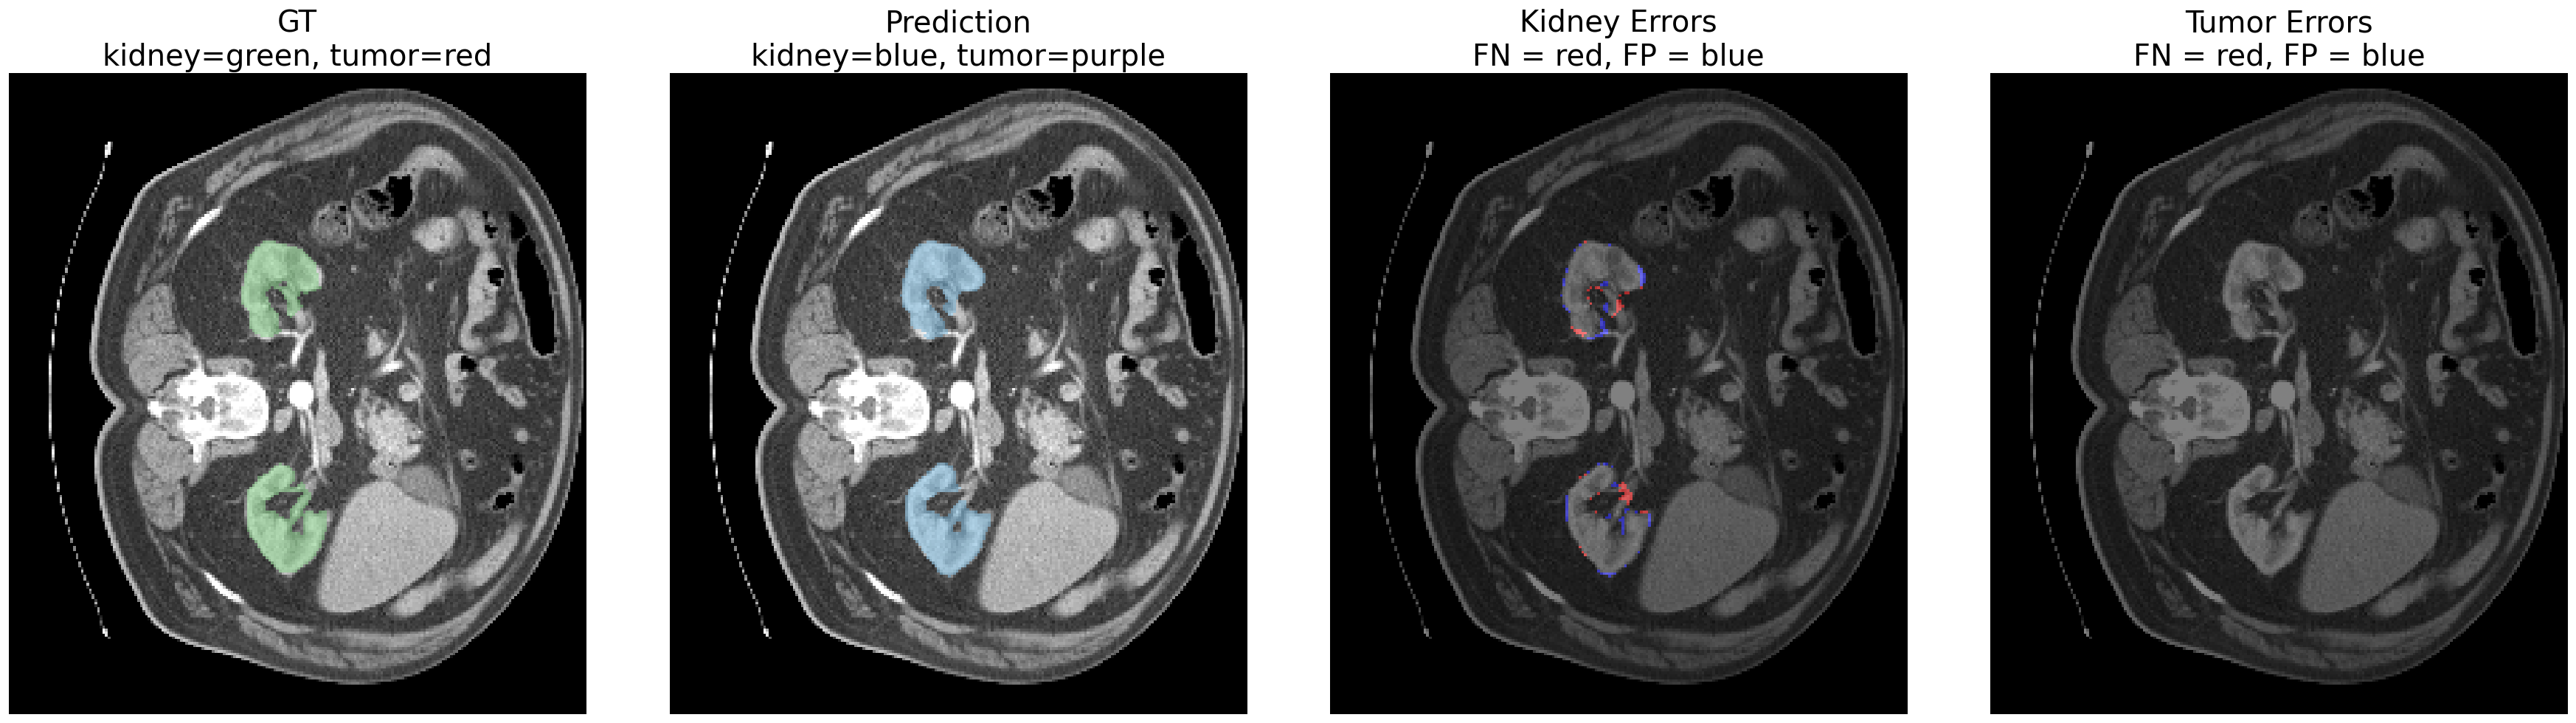

/home/philipdt/.local/lib/python3.10/site-packages/monai/inferers/utils.py:231: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = inputs[unravel_slice[0]].to(sw_device)
/home/philipdt/.local/lib/python3.10/site-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  out[idx_zm] += p


[sagittal slice 165] Dice scores:
  Kidney Dice   = 0.8726
  Tumor Dice    = 0.9090
  Foreground    = 0.9680



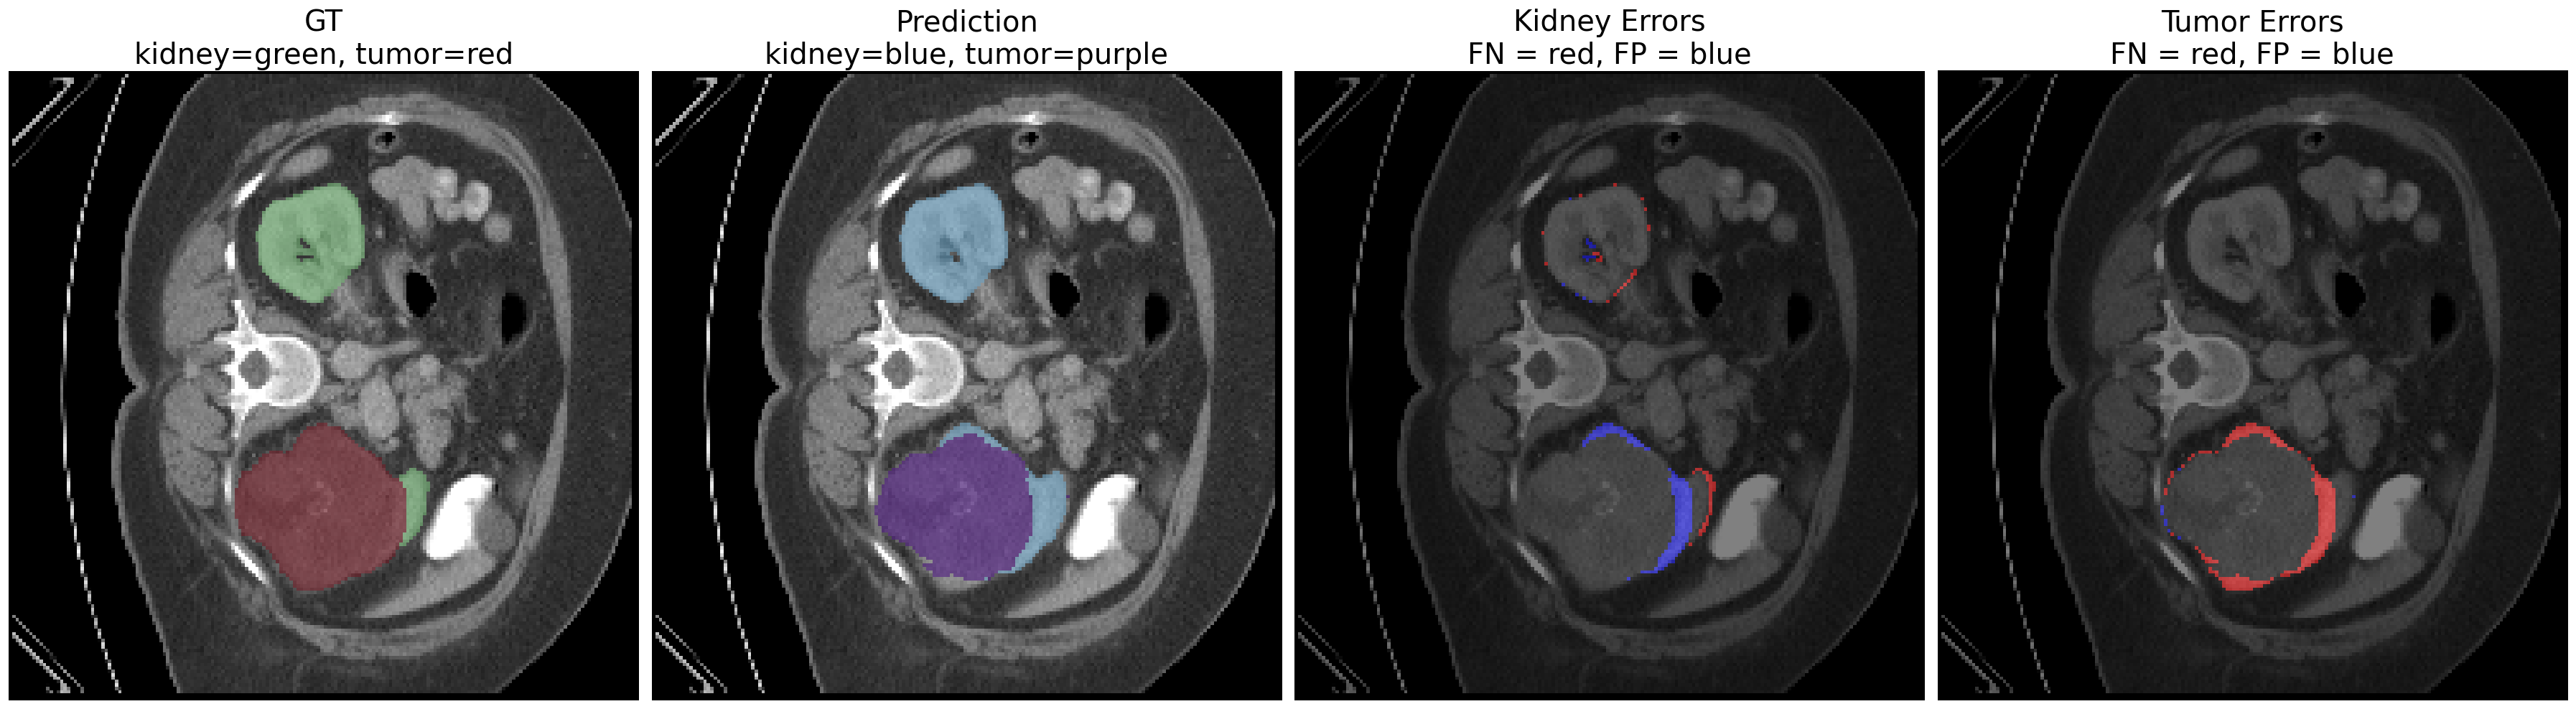

/home/philipdt/.local/lib/python3.10/site-packages/monai/inferers/utils.py:231: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = inputs[unravel_slice[0]].to(sw_device)
/home/philipdt/.local/lib/python3.10/site-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  out[idx_zm] += p


[sagittal slice 164] Dice scores:
  Kidney Dice   = 0.9609
  Tumor Dice    = 1.0000
  Foreground    = 0.9609



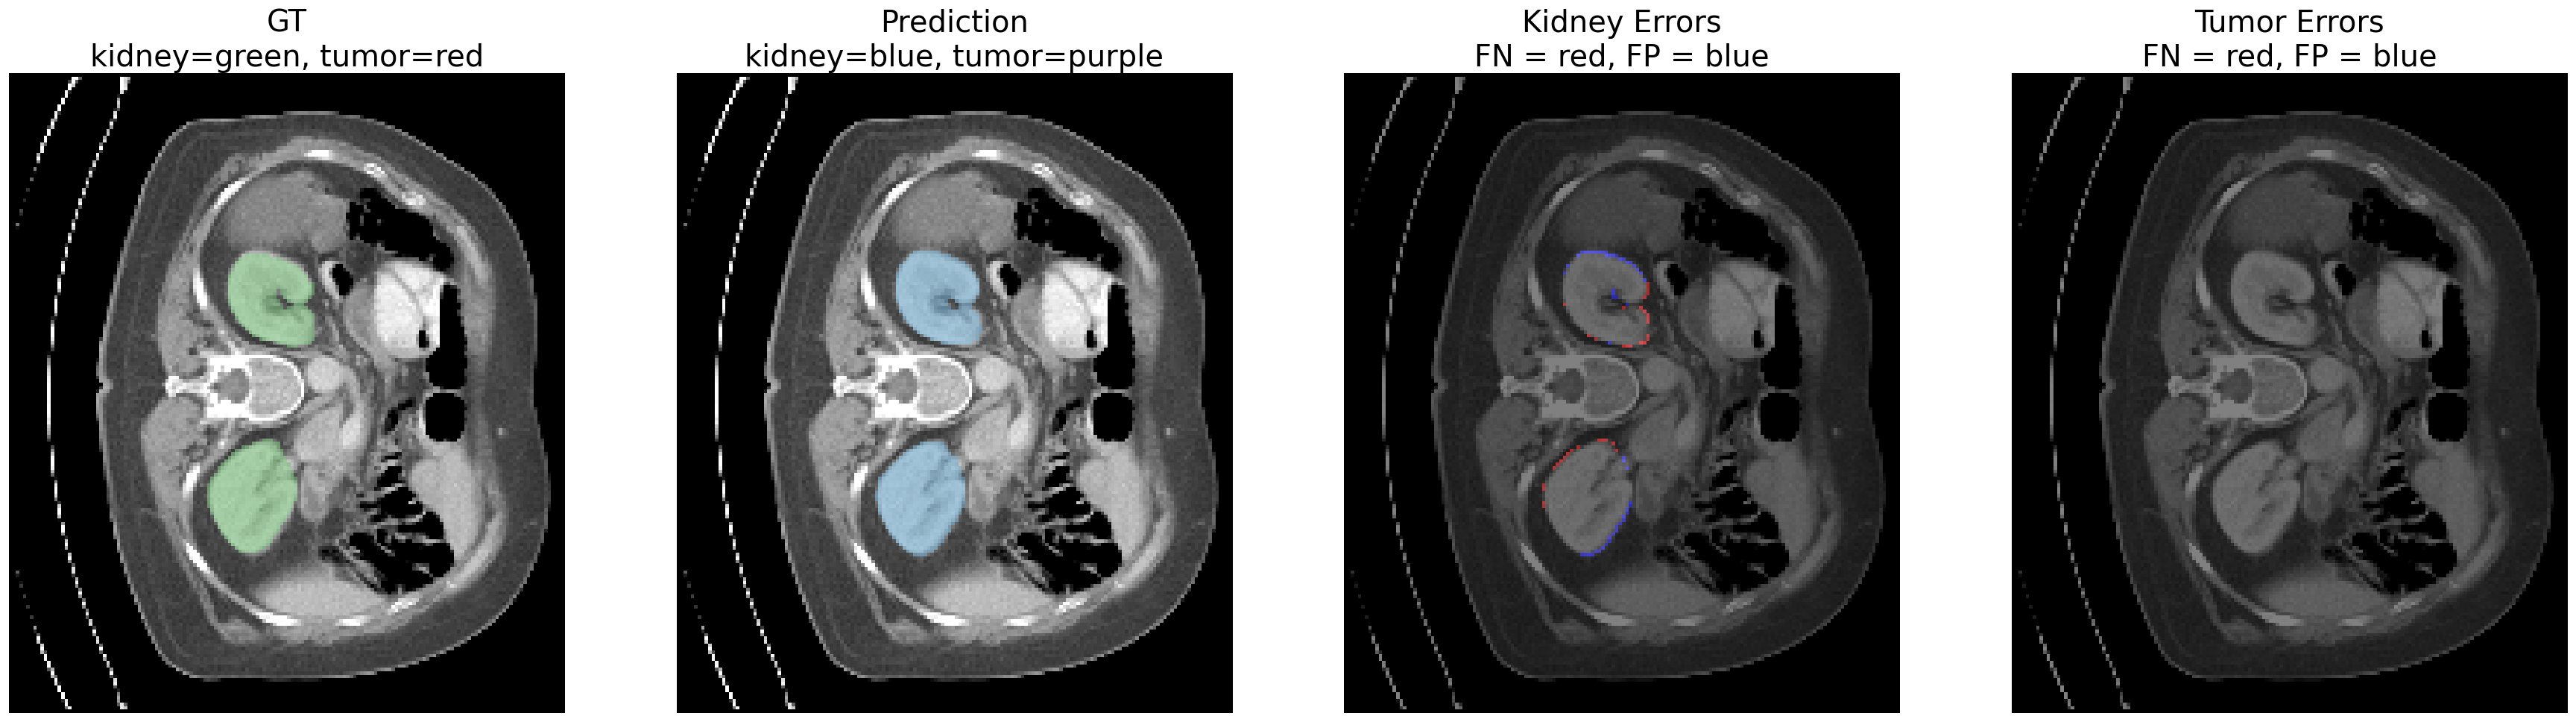

In [25]:
# ===================== Visualization + Dice for KiTS ===================== #
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import torch
from monai.inferers import sliding_window_inference

# Make figures larger / higher-res globally (optional)
plt.rcParams["figure.dpi"] = 120

def dice_score(pred, gt, label):
    """
    Computes Dice score for a single class `label`.
    pred, gt: 2D or 3D numpy arrays with integer class labels.
    label: class ID (1=kidney, 2=tumor for KiTS).
    """
    pred_bin = (pred == label)
    gt_bin   = (gt == label)

    intersection = np.logical_and(pred_bin, gt_bin).sum()
    total = pred_bin.sum() + gt_bin.sum()

    if total == 0:
        # If neither pred nor GT has this class, treat as perfect
        return 1.0 if intersection == 0 else 0.0

    return 2.0 * intersection / total


def show_val_examples(
    num_examples: int = 3,
    max_slices_per_volume: int = 1,
    choose_random_slice: bool = False,
    plane: str = "axial",  # "axial", "coronal", or "sagittal"
):
    """
    Visualize a few validation volumes with:
      - CT slice
      - GT overlay (kidney + tumor, colored)
      - Prediction overlay (kidney + tumor, colored)
      - Kidney error map (FN/FP)
      - Tumor error map (FN/FP)
      - Printed Dice scores (kidney, tumor, foreground) for each slice.
    """
    assert plane in ("axial", "coronal", "sagittal")
    axis_map = {"axial": 0, "coronal": 1, "sagittal": 2}
    slice_axis = axis_map[plane]

    def get_slice(vol, idx):
        # vol: (D, H, W)
        if plane == "axial":
            return vol[idx, :, :]
        elif plane == "coronal":
            return vol[:, idx, :]
        else:  # sagittal
            return vol[:, :, idx]

    model.eval()
    examples_shown = 0

    with torch.no_grad():
        for batch in val_loader:
            if examples_shown >= num_examples:
                break

            images = batch["image"].to(device)   # (B, 1, D, H, W)
            labels = batch["label"].to(device)   # (B, 1, D, H, W) or (B, D, H, W)

            # 3D inference
            logits = sliding_window_inference(
                images,
                roi_size=roi_size,
                sw_batch_size=1,
                predictor=model,
                overlap=0.5,
            )
            preds = torch.argmax(logits, dim=1)  # (B, D, H, W)

            if labels.dim() == 5:
                gts = labels.squeeze(1)          # (B, D, H, W)
            else:
                gts = labels                      # (B, D, H, W)

            # Single element in batch (assuming batch_size=1)
            img_np  = images.cpu().numpy()[0, 0]  # (D, H, W)
            gt_np   = gts.cpu().numpy()[0]        # (D, H, W)
            pred_np = preds.cpu().numpy()[0]      # (D, H, W)

            # Foreground amount per slice in chosen plane
            if plane == "axial":
                fg_per_slice = (gt_np > 0).sum(axis=(1, 2))
            elif plane == "coronal":
                fg_per_slice = (gt_np > 0).sum(axis=(0, 2))
            else:  # sagittal
                fg_per_slice = (gt_np > 0).sum(axis=(0, 1))

            num_slices = fg_per_slice.shape[0]
            slice_indices = []

            if fg_per_slice.max() > 0:
                sorted_idx = np.argsort(-fg_per_slice)  # descending
                for idx in sorted_idx:
                    if fg_per_slice[idx] == 0:
                        break
                    slice_indices.append(int(idx))
                    if len(slice_indices) >= max_slices_per_volume:
                        break
            else:
                # Fallback: center slice if no foreground
                slice_indices.append(int(num_slices // 2))

            if choose_random_slice and len(slice_indices) > 1:
                slice_indices = [int(np.random.choice(slice_indices))]

            # Try to extract case id from MONAI meta data (optional)
            case_id = None
            meta = batch.get("image_meta_dict", None)
            if meta is not None:
                fname = meta.get("filename_or_obj", None)
                if isinstance(fname, (list, tuple)):
                    fname = fname[0]
                if fname is not None:
                    fname = str(fname)
                    base = os.path.basename(fname)
                    m = re.search(r"case_\d+", base)
                    case_id = m.group(0) if m else base

            for slice_idx in slice_indices:
                if examples_shown >= num_examples:
                    break

                sl_img  = get_slice(img_np, slice_idx)    # (H, W)
                sl_gt   = get_slice(gt_np, slice_idx)     # (H, W)
                sl_pred = get_slice(pred_np, slice_idx)   # (H, W)

                # ---- Dice scores (per-slice) ----
                dice_kidney = dice_score(sl_pred, sl_gt, 1)    # class 1
                dice_tumor  = dice_score(sl_pred, sl_gt, 2)    # class 2
                fg_pred = (sl_pred > 0).astype(np.uint8)
                fg_gt   = (sl_gt > 0).astype(np.uint8)
                dice_fg = dice_score(fg_pred, fg_gt, 1)        # foreground as class 1

                print(f"[{plane} slice {slice_idx}] Dice scores:")
                if case_id is not None:
                    print(f"  Case: {case_id}")
                print(f"  Kidney Dice   = {dice_kidney:.4f}")
                print(f"  Tumor Dice    = {dice_tumor:.4f}")
                print(f"  Foreground    = {dice_fg:.4f}\n")

                # Intensity windowing for nicer contrast
                vmin = np.percentile(sl_img, 1)
                vmax = np.percentile(sl_img, 99)

                # 5 panels: image, GT, pred, kidney errors, tumor errors
                fig, axs = plt.subplots(1, 4, figsize=(30, 8))


                # 1) GT overlay — kidney vs tumor
                axs[0].imshow(sl_img, cmap="gray", vmin=vmin, vmax=vmax)
                gt_kidney = np.ma.masked_where(sl_gt != 1, sl_gt)
                gt_tumor  = np.ma.masked_where(sl_gt != 2, sl_gt)
                axs[0].imshow(gt_kidney, cmap="Greens", alpha=0.5, vmin=0, vmax=2)
                axs[0].imshow(gt_tumor,  cmap="Reds",   alpha=0.5, vmin=0, vmax=2)
                axs[0].set_title("GT\nkidney=green, tumor=red",fontsize=24)
                axs[0].axis("off")

                # 2) Prediction overlay — kidney vs tumor
                axs[1].imshow(sl_img, cmap="gray", vmin=vmin, vmax=vmax)
                pred_kidney = np.ma.masked_where(sl_pred != 1, sl_pred)
                pred_tumor  = np.ma.masked_where(sl_pred != 2, sl_pred)
                axs[1].imshow(pred_kidney, cmap="Blues",   alpha=0.5, vmin=0, vmax=2)
                axs[1].imshow(pred_tumor,  cmap="Purples", alpha=0.5, vmin=0, vmax=2)
                axs[1].set_title("Prediction\nkidney=blue, tumor=purple",fontsize=24)
                axs[1].axis("off")

                # 3) Kidney FN / FP
                fn_kidney = (sl_gt == 1) & (sl_pred != 1)
                fp_kidney = (sl_gt != 1) & (sl_pred == 1)

                overlay_kidney = np.zeros(sl_img.shape + (3,), dtype=float)
                overlay_kidney[..., 0][fn_kidney] = 1.0   # red = FN
                overlay_kidney[..., 2][fp_kidney] = 1.0   # blue = FP

                axs[2].imshow(sl_img, cmap="gray", vmin=vmin, vmax=vmax)
                axs[2].imshow(overlay_kidney, alpha=0.5)
                axs[2].set_title("Kidney Errors\nFN = red, FP = blue",fontsize=24)
                axs[2].axis("off")

                # 4) Tumor FN / FP
                fn_tumor = (sl_gt == 2) & (sl_pred != 2)
                fp_tumor = (sl_gt != 2) & (sl_pred == 2)

                overlay_tumor = np.zeros(sl_img.shape + (3,), dtype=float)
                overlay_tumor[..., 0][fn_tumor] = 1.0   # red = FN
                overlay_tumor[..., 2][fp_tumor] = 1.0   # blue = FP

                axs[3].imshow(sl_img, cmap="gray", vmin=vmin, vmax=vmax)
                axs[3].imshow(overlay_tumor, alpha=0.5)
                axs[3].set_title("Tumor Errors\nFN = red, FP = blue",fontsize=24)
                axs[3].axis("off")

                plt.tight_layout()
                # Descriptive filename (saved in current directory)
                fname_parts = [
                    f"case_{case_id}" if case_id is not None else "unknown_case",
                    f"{plane}",
                    f"slice_{slice_idx}"
                ]
                fname = "_".join(fname_parts) + ".pdf"
                
                plt.savefig(fname, dpi=300, bbox_inches="tight")
                plt.show()

                examples_shown += 1
# 

# Example usage:
#show_val_examples(num_examples=3, max_slices_per_volume=1, plane="axial")
#show_val_examples(num_examples=3, max_slices_per_volume=1, plane="coronal")
show_val_examples(num_examples=5, max_slices_per_volume=1, plane="sagittal")


In [ ]:
# =============== Inference on test set (save NIfTI, custom Dice) =============== #
import torch
import numpy as np
from pathlib import Path

from monai.inferers import sliding_window_inference
from monai.transforms import SaveImage

# -------- Simple Dice implementation (volume-wise) --------
def dice_score_volume(pred, gt, label):
    """
    pred, gt: 3D numpy arrays with integer class labels (D, H, W)
    label: class ID to compute Dice for (e.g. 1=kidney, 2=tumor).
    """
    pred_bin = (pred == label)
    gt_bin   = (gt == label)

    intersection = np.logical_and(pred_bin, gt_bin).sum()
    total = pred_bin.sum() + gt_bin.sum()

    if total == 0:
        # If neither pred nor GT has this class, treat as perfect match
        return 1.0 if intersection == 0 else 0.0

    return 2.0 * intersection / total


# -------- 1. Load best checkpoint for this run --------
run_dir   = Path(out_dir)  # out_dir should already point to runX
ckpt_path = run_dir / "model_best.pth"
print(f"Loading best model from: {ckpt_path}")

checkpoint = torch.load(ckpt_path, map_location=device)

# Handle both: pure state_dict OR dict with 'model'
if isinstance(checkpoint, dict) and "model" in checkpoint:
    state_dict = checkpoint["model"]
else:
    state_dict = checkpoint

model.load_state_dict(state_dict)
model.eval()

# Folder to save predictions
pred_save_dir = run_dir / "predictions_test"
pred_save_dir.mkdir(parents=True, exist_ok=True)

saver = SaveImage(
    output_dir=str(pred_save_dir),
    output_dtype=np.uint8,
    output_postfix="pred",      # will append "_pred"
    separate_folder=False,      # all files directly in predictions_test
    squeeze_end_dims=True,
)

# For aggregating Dice over the whole val set
kidney_dice_list = []
tumor_dice_list  = []
fg_dice_list     = []

# -------- 2. Inference loop (no gradients) --------
with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        images = batch["image"].to(device)   # (B, 1, D, H, W)
        labels = batch["label"].to(device)   # (B, 1, D, H, W)

        # Forward pass / sliding window inference
        logits = sliding_window_inference(
            images,
            roi_size=roi_size,
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )  # (B, C, D, H, W)

        # Hard labels for saving & metrics: (B, 1, D, H, W)
        preds = torch.argmax(logits, dim=1, keepdim=True)

        # ---- Per-volume custom Dice (kidney, tumor, foreground) ----
        for i in range(preds.shape[0]):
            pred_vol = preds[i, 0].cpu().numpy()   # (D, H, W)
            gt_vol   = labels[i, 0].cpu().numpy()  # (D, H, W)

            d_kidney = dice_score_volume(pred_vol, gt_vol, label=1)
            d_tumor  = dice_score_volume(pred_vol, gt_vol, label=2)

            # Foreground = {1,2}, map to binary {0,1}
            pred_fg = (pred_vol > 0).astype(np.uint8)
            gt_fg   = (gt_vol > 0).astype(np.uint8)
            d_fg    = dice_score_volume(pred_fg, gt_fg, label=1)

            kidney_dice_list.append(d_kidney)
            tumor_dice_list.append(d_tumor)
            fg_dice_list.append(d_fg)

        # ---- Save predictions as NIfTI using SaveImage ----
        meta = batch.get("image_meta_dict", None)  # may be None

        for i in range(preds.shape[0]):
            if meta is not None:
                saver(
                    preds[i],                                  # (1, D, H, W)
                    meta_data={k: meta[k][i] for k in meta},   # ith metadata item
                )
            else:
                saver(preds[i])

# -------- 3. Aggregate and report custom Dice --------
mean_kidney_dice = float(np.mean(kidney_dice_list)) if kidney_dice_list else float("nan")
mean_tumor_dice  = float(np.mean(tumor_dice_list))  if tumor_dice_list  else float("nan")
mean_fg_dice     = float(np.mean(fg_dice_list))     if fg_dice_list     else float("nan")

print("\n✅ Inference on val set done (custom Dice).")
print(f"   Mean Kidney Dice     = {mean_kidney_dice:.4f}")
print(f"   Mean Tumor Dice      = {mean_tumor_dice:.4f}")
print(f"   Mean Foreground Dice = {mean_fg_dice:.4f}")
print(f"   Predictions saved to: {pred_save_dir}")
